In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import OrderedDict
import math
from sklearn.preprocessing import MinMaxScaler


# 数据理解

目标：

    1、对于每个店铺，预测这个店铺每个商品在某个月的销量。

表说明：

    1、test.csv：测试数据表，其中仅含有店铺id和item_id这两个特征。
    2、sales_train.csv:训练数据表。有每个店铺每个种商品34个月每天的销量数据。还有商品价格。
    3、items.csv：商品的名称，id和类别id信息
    4、item_categories.csv：类别名字
    5、shops.csv：店铺信息

问题：

    1、不是所有的店铺都需要预测。
    2、不是所有的商品都需要预测。
    3、训练特征和测试特征量不匹配。
    4、月份日期是从2013年1月开始（记为0），到2015年10月（记为33），预测2015年11月的一个整个月每个店铺每个商品的销量
    



In [2]:
shop_df=pd.read_csv('./data/shops.csv')
shop_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [3]:
item_category_df=pd.read_csv('./data/item_categories.csv')
item_category_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [4]:
df_test=pd.read_csv('./data/test.csv')
df_test.head() # 特征就给了两个…需要自己加特征

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
len(df_test['shop_id'].value_counts())

42

In [6]:
item_data=pd.read_csv('data/items.csv')
print(item_data.shape)
item_data.head()

(22170, 3)


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
train_data_raw=pd.read_csv('data/sales_train_v2.csv')
train_data_raw.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [8]:
len(train_data_raw['shop_id'].value_counts())

60

In [9]:
sample_sub=pd.read_csv('data/sample_submission.csv')
sample_sub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


# Baseline

    1、想法很简单，根据测试数据，从训练数据中筛选出目标店铺和商品。
    2、按月统计。
    3、对于店铺A中的商品a，将33个月的均值作为其预测值

In [47]:
'''
获取目标商店id和商品id
'''
# 获取测试的商店
shop_list=list(set(df_test['shop_id'].tolist()))
# 获取测试的商品
item_list=list(set(df_test['item_id'].tolist()))

In [54]:
'''
筛选出仅含目标商店id和商品id的记录
'''
# 筛选出仅含目标商店的记录
target_df=train_data_raw[train_data_raw['shop_id'].isin(shop_list)]
# 筛选出仅含目标商店和目标商品的记录
target_df=target_df[target_df['item_id'].isin(item_list)]
target_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
10,03.01.2013,0,25,2574,399.0,2.0
11,05.01.2013,0,25,2574,399.0,1.0
12,07.01.2013,0,25,2574,399.0,1.0
13,08.01.2013,0,25,2574,399.0,2.0


In [55]:
'''
根据商店id进行分组
'''
shop_dict={}
for key,value in target_df.groupby('shop_id'):
    shop_dict[key]=value

In [56]:
'''
对于每个商店，按照月份，对每种商品进行销量统计
'''
shop_dict.keys()
final_result_dict={}

# 结果list
result_dict={}
for ID,shop_id,item_id in zip(df_test['ID'].tolist(),df_test['shop_id'].tolist(),df_test['item_id'].tolist()):
    result_dict[str(shop_id)+"_"+str(item_id)]=ID

print(len(result_dict))
    
# 对每个商店
for shop_id in shop_dict.keys():
    first_shop=shop_dict[shop_id]
    
    # 对月id和item_id进行groupby，并对其余几项计算sum
    # 得到的是该店铺，每个商品，在每个月的总销量
    first_result=first_shop.groupby(['date_block_num','item_id']).sum()
    
    # 对上面结果，对item_id进行group_by，并对其余几项计算mean
    # 得到的是该店铺，每个商品，在33个月的月平均销量
    first_final_result=first_result.groupby('item_id').mean()

    # 结果
    first_item_id=first_final_result.index.tolist()
    first_item_cnt=first_final_result['item_cnt_day'].tolist()


    for item_id,item_cnt in zip(first_item_id,first_item_cnt):
        final_result_dict[result_dict[str(shop_id)+'_'+str(item_id)]]=item_cnt


# 算下来有近一半的数据是没有的…= -         
len(final_result_dict)
# first_shop


214200


111404

In [57]:
'''
构建提交结果
这个结果大概是1967名，总共2087名
嘛，看起来作为一个baseline足够了
'''
sub_result=[]
for i in range(df_test.shape[0]):
    sub_result.append(final_result_dict.get(i,0))


my_sub_df=pd.DataFrame({'ID':list(range(df_test.shape[0])),'item_cnt_month':sub_result})
len(sub_result)
my_sub_df.to_csv('./my_sub/20190110_mean_baseline.csv',index=False)
my_sub_df.head()

,ID,item_cnt_month
0,0,1.444444
1,1,0.000000
2,2,2.000000
3,3,1.000000
4,4,0.000000


# 机器学习方法

方法总结：

    1、常用的传统机器学习方法做回归：
        决策树回归
        随机森林回归
        SVR
        L1，L2回归
        GBDT
        LGBM
    2、深度学习方法：
        MLP
        RNN
        其他例如WaveNet之类奇怪的网络

步骤：

    1、由于训练集和测试集的信息格式不一样（训练集按天给，测试集需要月的预测）不对等，需要进行对应的处理。
    2、特征太少，我们需要做一下特征工程。
    

In [93]:
'''
总的目标是将数据处理成和测试数据一样[店铺id,商品id]这样的格式，然后在考虑添加信息
'''
def get_month_sales(source_data,target_data,do_filter=True,label=['item_cnt_day']):

    '''
    获取目标商店id和商品id
    '''
    # 获取测试的商店
    shop_list=list(set(target_data['shop_id'].tolist()))
    # 获取测试的商品
    item_list=list(set(target_data['item_id'].tolist()))

    '''
    筛选出仅含目标商店id和商品id的记录
    '''
    if do_filter:
        # 筛选出仅含目标商店的记录
        target_df=source_data[source_data['shop_id'].isin(shop_list)]
    #     筛选出仅含目标商店和目标商品的记录
        target_df=target_df[target_df['item_id'].isin(item_list)]
#         target_df.head()
    else:
        target_df=source_data

    '''
    根据商店id进行分组
    '''
    shop_dict={}
    for key,value in target_df.groupby('shop_id'):
        shop_dict[key]=value

    item_id_list=[]
    date_block_num_list=[]
    shop_id_list=[]
    item_cnt_list=[]


    # 对每个商店
    for shop_id in shop_dict.keys():
        # 拿到这个商店所有的信息
        first_shop=shop_dict[shop_id]
        # 拿到这个商店每个月的信息
        first_shop_month={}
        for key,value in first_shop.groupby('date_block_num'):
            first_shop_month[key]=value

        # 拿到这个商店，每个月，这个商品的全月销量
        for key in first_shop_month.keys():
            temp_sum=first_shop_month[key].groupby('item_id').sum()

            item_id_list+=temp_sum.index.tolist()
            date_block_num_list+=[key]*len(temp_sum)
            shop_id_list+=[shop_id]*len(temp_sum)
            item_cnt_list+=temp_sum[label[0]].tolist()

    '''
    将月份转换成0~11月（共12个月）
    并构建新的dataframe
    '''
    date_block_num_list_cate=[ (aa+1)%12 for aa in date_block_num_list]
    my_new_df=pd.DataFrame({'item_id':item_id_list,'date_block_num':date_block_num_list,
                            'date_block_num_cate':date_block_num_list_cate,
                            'shop_id':shop_id_list,'item_cnt':item_cnt_list})
    
    return my_new_df
        

In [30]:
my_new_df=get_month_sales(train_data_raw,df_test)

In [13]:
my_new_df

,date_block_num,date_block_num_cate,item_cnt,item_id,shop_id
0,0,1,1.0,33,2
1,0,1,1.0,482,2
2,0,1,1.0,491,2
3,0,1,1.0,839,2
4,0,1,3.0,1007,2
5,0,1,1.0,1010,2
6,0,1,2.0,1023,2
7,0,1,1.0,1204,2
8,0,1,1.0,1224,2
9,0,1,1.0,1247,2


## 尝试1：随机森林法

    1、划分训练集和测试集：
        1.1 所有店铺2015年10月份的数据作为测试集
        1.2 剩下的作为验证集

In [13]:
from sklearn.ensemble import RandomForestRegressor

E:\Python\PY3.6\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [14]:

# 划分训练数据和测试数据
test_data=my_new_df[my_new_df.data_block_num==33]
train_data=my_new_df[my_new_df.data_block_num!=33]

In [15]:
# 定义label和feature
features=['data_block_num_cate','item_id','shop_id']
label=['item_cnt']

In [16]:
'''
拿到train和tset数据
'''
train_x=train_data[features]
train_y=train_data[label]

test_x=test_data[features]
test_y=test_data[label]

In [17]:
RandomForestRegressor??

In [18]:
forest = RandomForestRegressor(n_estimators = 500,criterion='mse',
                                      random_state=1,n_jobs=-1)

In [19]:
forest.fit(train_x,train_y)

E:\Python\PY3.6\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [20]:
pred_y=forest.predict(test_x)

In [22]:
# 感觉有点高啊…
pred_y=np.asarray(pred_y,dtype=np.float32)
test_y=np.asarray(test_y,dtype=np.float32)
rmse(pred_y,test_y)

array([14.357409], dtype=float32)

In [154]:
# 全量训练
all_train_x=my_new_df[features]
all_train_y=my_new_df[label]

In [155]:
all_forest = RandomForestRegressor(n_estimators = 1000,criterion='mse',
                                      random_state=1,n_jobs=-1)

In [156]:
all_forest.fit(all_train_x,all_train_y)

E:\Python\PY3.6\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [157]:
all_train_x.head()

,data_block_num_cate,item_id,shop_id
0,1,33,2
1,1,482,2
2,1,491,2
3,1,839,2
4,1,1007,2


In [162]:
df_test['data_block_num_cate']=[11]*df_test.shape[0]
pred_sub=all_forest.predict(df_test[features])

In [166]:
# 提交结果

# 妈呀，这个结果8.多的loss，效果超差
my_sub_forest_df=pd.DataFrame({'ID':list(range(df_test.shape[0])),'item_cnt_month':pred_sub.tolist()})
my_sub_forest_df.head()
my_sub_forest_df.to_csv('./my_sub/20190110_forest.csv',index=False)

## 尝试2：GBDT

    1、random-forest的效果很差，检查了数据，觉得不是数据问题，问题应该出在forest本身。
    2、因为特征太少了，（一共就3个特征），最深也就3层的数，但是需要预测范围又比较广，因此效果可能不是很好。
    3、我们现在看一下GBDT的效果

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

In [65]:
def train_rfr(rfr_raw_data,features=['item_id','shop_id'],label=['item_cnt_day']):
    
#     print(rfr_raw_data.head())
    
    # 划分训练数据和测试数据
    test_data=rfr_raw_data[rfr_raw_data.date_block_num==33]
    train_data=rfr_raw_data[rfr_raw_data.date_block_num!=33]
    # 定义label和feature
#     features=['item_id','shop_id']
#     label=['item_cnt_day']
    '''
    拿到train和tset数据
    '''
    train_x=train_data[features]
    train_y=train_data[label]

    test_x=test_data[features]
    test_y=test_data[label]
    
#     print(test_x.head())
    
    rfr = GradientBoostingRegressor()
    
    rfr.fit(train_x,train_y)
    
    predict_rfr=rfr.predict(test_x)
    
    print(rmse(predict_rfr,test_y))
    
    plt.subplot(2, 1, 1)
    plt.plot(predict_rfr,'r')
    plt.subplot(2, 1, 2)
    plt.plot(test_y,'y')
    
    
    return rfr

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
         item_id  shop_id
2882335    13315       45
2882336    13880       45
2882337    13881       45
2882338    13881       45
2882339    13923       45


E:\Python\PY3.6\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[9.7445135]


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

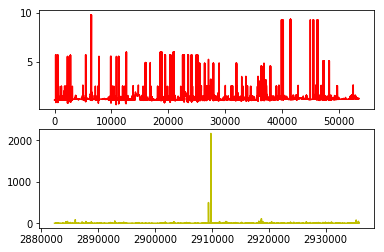

In [53]:
# 用每天的数据来预测每月的数据…
# 最后得到的结果，在kagle上RMSE在1.48536
train_rfr(train_data_raw)

   date_block_num  date_block_num_cate  item_cnt  item_id  shop_id
0               0                    1       6.0       32        0
1               0                    1       3.0       33        0
2               0                    1       1.0       35        0
3               0                    1       1.0       43        0
4               0                    1       2.0       51        0
       item_id  shop_id
23216       31        2
23217      486        2
23218      787        2
23219      794        2
23220      968        2


E:\Python\PY3.6\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[13.976871]


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

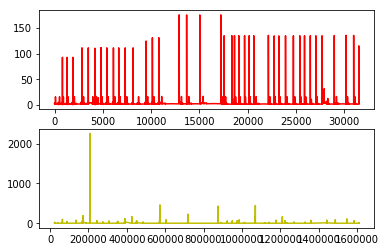

In [52]:
# 这里直接用每月的数据来测每月的数据…效果奇差
# 感觉是不是要再看一下数据…= - 
train_rfr(my_new_df,features=['item_id','shop_id'],label=['item_cnt'])

In [69]:
pred_rfr_raw=rfr.predict(df_test[features])

In [70]:
my_result_tocsv(pred_rfr_raw,'20190110_rfr_raw.csv')

In [58]:
train_data_raw.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [98]:
aa=[1]
bb=[2]
aa+bb

[1, 2]

## 问题查找

    1、在不同的数据划分上，模型的表现效果截然不同。
    2、但是根据我对数据的理解，应该是我的方法划分后的数据才对呀。
    3、这里根据模型和划分后的数据进行一次检验

猜想1：

    1、商品的类别数量下降？因为我的数据集是根据最终所需要预测的商品，从训练集中过滤出来的子集。
    2、但用原始数据集，那就是根据所有的数据进行训练了。
    
    验证：
    1、去全量数据进行验证了，发现效果其实一般…从14.3几的rmse降到了现在13.9几= - 
    说明这个而其实并不是主要问题。

猜想2：

    1、观察了全量数据预测图和我处理后的数据的预测图，发现数据的范围有比较大的差别。
    2、那么对数据进行归一化会不会好一些
   

### 猜想1测试

猜想1：

    1、商品的类别数量下降？因为我的数据集是根据最终所需要预测的商品，从训练集中过滤出来的子集。
    2、但用原始数据集，那就是根据所有的数据进行训练了。
    
    验证：
    1、去全量数据进行验证了，发现效果其实一般…从14.3几的rmse降到了现在13.9几= - 
    说明这个而其实并不是主要问题。

E:\Python\PY3.6\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[14.423452]


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

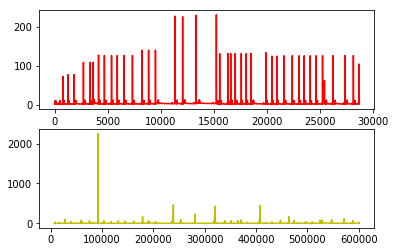

In [66]:
'''
过滤了item和商店的数据
'''
filtered_data=get_month_sales(train_data_raw,df_test)
train_rfr(filtered_data,features=['item_id','shop_id'],label=['item_cnt'])

E:\Python\PY3.6\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[13.976871]


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

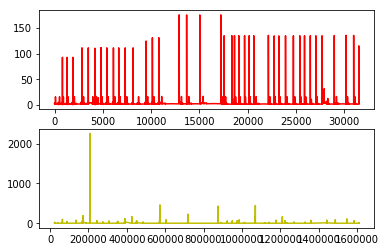

In [67]:
'''
没过滤item和商店的数据
'''
no_filtered_data=get_month_sales(train_data_raw,df_test,do_filter=False)
train_rfr(no_filtered_data,features=['item_id','shop_id'],label=['item_cnt'])

### 猜想2测试

猜想2：

    1、观察了全量数据预测图和我处理后的数据的预测图，发现数据的范围有比较大的差别。
    2、那么对数据进行归一化会不会好一些
    
归一化后，用我构造的数据，在测试集上loss为2.8几，用原始数据大概在1.4几…唉= - 

In [82]:
aaa=np.asarray([[0],[1],[2],[3],[4]])
print(aaa.shape)
scaler=MinMaxScaler()
# 获得归一化数据
scaled_data=scaler.fit_transform(aaa)
print(scaled_data)
# 反归一化
reversed_scaler=scaler.inverse_transform(scaled_data)
print(reversed_scaler)

(5, 1)
[[0.  ]
 [0.25]
 [0.5 ]
 [0.75]
 [1.  ]]
[[0.]
 [1.]
 [2.]
 [3.]
 [4.]]


E:\Python\PY3.6\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [87]:
'''
为了比较两个模型的效果，我们将两种数据都进行归一化
'''
temp_item_cnt_day=np.asarray(train_data_raw['item_cnt_day'])
temp_item_cnt_day=np.reshape(temp_item_cnt_day,(len(temp_item_cnt_day),1))
temp_scaler=MinMaxScaler()
temp_item_cnt_day=temp_scaler.fit_transform(temp_item_cnt_day)

train_data_raw['item_cnt_day_nor']=temp_item_cnt_day

In [88]:
train_data_raw.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_day_nor
0,02.01.2013,0,59,22154,999.00,1.0,0.010497
1,03.01.2013,0,25,2552,899.00,1.0,0.010497
2,05.01.2013,0,25,2552,899.00,-1.0,0.009585
3,06.01.2013,0,25,2554,1709.05,1.0,0.010497
4,15.01.2013,0,25,2555,1099.00,1.0,0.010497


E:\Python\PY3.6\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.0044455]


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

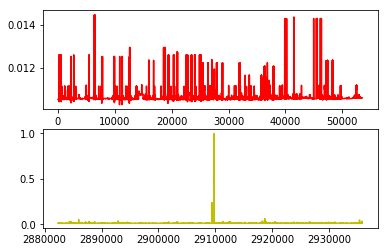

In [109]:
my_rough_data_model=train_rfr(train_data_raw,label=['item_cnt_day_nor'])
my_rough_data_model

In [112]:
features=['item_id','shop_id']
rough_pred_result=model_test(my_rough_data_model,df_test[features])

rough_pred_result=np.reshape(rough_pred_result,(len(rough_pred_result),1))
rough_pred_result=temp_scaler.inverse_transform(rough_pred_result)

rough_pred_result=np.reshape(rough_pred_result,(len(rough_pred_result),))

my_result_tocsv(rough_pred_result,'20190111_rfr_rough_nor.csv')

In [98]:
'''
不做filter,用我这个类型的数据
'''
my_new_df_scaler=get_month_sales(train_data_raw,df_test,do_filter=False)
my_new_df_scaler.head()

,date_block_num,date_block_num_cate,item_cnt,item_id,shop_id
0,0,1,6.0,32,0
1,0,1,3.0,33,0
2,0,1,1.0,35,0
3,0,1,1.0,43,0
4,0,1,2.0,51,0


In [100]:
my_scaler=MinMaxScaler()
my_temp_item_cnt=np.asarray(my_new_df_scaler['item_cnt'])
my_temp_item_cnt=np.reshape(my_temp_item_cnt,(len(my_temp_item_cnt),1))
my_temp_item_cnt_scaled=my_scaler.fit_transform(my_temp_item_cnt)
my_new_df_scaler['item_cnt_nor']=my_temp_item_cnt_scaled

E:\Python\PY3.6\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0.00614366]


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

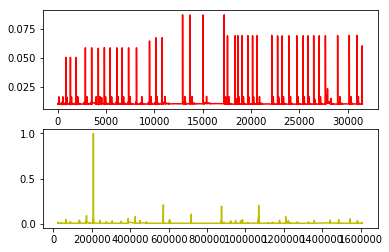

In [102]:
my_rfr_model=train_rfr(my_new_df_scaler,features=['item_id','shop_id'],label=['item_cnt_nor'])
my_rfr_model

In [108]:
features=['item_id','shop_id']
pred_result=model_test(my_rfr_model,df_test[features])

pred_result=np.reshape(pred_result,(len(pred_result),1))
pred_result=my_scaler.inverse_transform(pred_result)
pred_result=np.reshape(pred_result,(len(pred_result),))

my_result_tocsv(pred_result,'20190111_rfr_nor.csv')

### 猜想3

    1、现在猜想是这样。
        1.1 测试的特征中，没有任何一项特征能够体现出它是月度数据的。
        1.2 很多商品月度的销售量和当月某个日的销售量一样（这个月就卖了那天一次）
        1.3 在此基础上，没有做聚合的数据，无疑多了很多样本，从而让模型能够更好的训练…
    
    罢了罢了…就用这个数据吧= - 

In [31]:
'''
获得按照我的意愿划分的数据
并且有筛选，仅选择在最终预测中所需要的商品item，进行预测。
'''
my_new_df=get_month_sales(train_data_raw,df_test)

In [32]:
find_train_data=my_new_df[my_new_df['date_block_num']!=33]
find_train_data_raw=train_data_raw[train_data_raw['date_block_num']!=33]

find_test_data=my_new_df[my_new_df['date_block_num']==33]
find_test_data_raw=train_data_raw[train_data_raw['date_block_num']==33]

In [33]:
len(set(find_test_data['item_id'].tolist()))

5413

In [34]:
len(set(find_test_data_raw['item_id'].tolist()))

5413

# support function

In [39]:
def rmse(y1,y2):
    y1=np.asarray(y1,dtype=np.float32)
    y2=np.asarray(y2,dtype=np.float32)
    result=[ (a-b)**2 for a,b in zip(y1,y2)]
    rmse=sum(result)/len(result)
    return rmse**0.5

In [40]:
def model_test(model,final_test):
    return model.predict(final_test)

In [41]:
def my_result_tocsv(pred_sub,name):
    my_sub_forest_df=pd.DataFrame({'ID':list(range(df_test.shape[0])),'item_cnt_month':pred_sub.tolist()})
    my_sub_forest_df.head()
    my_sub_forest_df.to_csv('./my_sub/'+name,index=False)